# TOLIMAN Jitter Analysis

In [1]:
import os

# jax
import dLux as dl
import dLuxToliman as dlT
import jax
from jax import device_count
from jax import random as jr
from jax import numpy as np
import jax.scipy as jsp

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import zodiax as zdx
import optax

%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
print(jax.devices())

[CudaDevice(id=0)]


In [ ]:
def run_grad_desc(
        model,
        data,
        params,
        optimisers: dict,
        loss_func,
        iters=100,
        plot=False,
        verbose=True,
        eps=3e-4, # termination condition
        ):
    """
    Run gradient descent on a model.
    """

    # run gradient descent
    optim, opt_state = zdx.get_optimiser(model, params, optimisers)
    losses, models_out = [], []

    if verbose:
        t = tqdm(range(iters), desc='Gradient Descent')
    else:
        t = range(iters)
        
    for i in t: 

        # for termination condition
        last_params = model.get(params)

        loss, grads = loss_func(model, data)
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)

        models_out.append(model)
        losses.append(loss)

        # if np.isnan(np.array(grads.get(params))).sum() != 0:
        #     raise ValueError("NaN gradient")
        # if np.isneginf(np.array(grads.get(params))).sum() != 0:
        #     raise ValueError("Neginf gradient")
        
        if verbose:
            t.set_description("Loss: {:.6e}".format(loss)) # update the progress bar

        # Terminating condition
        new_params = model.get(params)  # getting new parameters
        scaled_diffs = jax.tree.map(  
            lambda x, y: np.abs((x - y)/y),
            last_params,
            new_params,
            )
        if np.all(np.array(  # if all parameters have converged
            jax.tree.map(lambda x: np.all(x < eps), scaled_diffs)
            )):
            break

    if plot:
        plt.figure()
        plt.title("Log Poisson Loss")
        plt.xlabel("Epoch")
        plt.plot(range(i+1), losses)
        plt.show()

        plt.figure()
        for param in params:
            param_out = np.array([m.get(param) for m in models_out])
            if param_out.size//iters > 1:
                plt.plot(range(i+1), param_out - param_out[0], label=param)
            else:
                plt.plot(range(i+1), param_out, label=param)
            plt.xlabel("Epoch")
            plt.legend()
            plt.show()


    return models_out[-1]

In [3]:
from dLuxToliman import AlphaCen
from jax import Array
import dLux
from zodiax import filter_vmap

Source = lambda: dLux.BaseSource
Optics = lambda: dLux.BaseOpticalSystem

class AlphaCenMeanWavel(AlphaCen):

    n_wavels : int
    mean_wavelength : float

    def __init__(
        self,
        n_wavels=3,
        separation=10.0,  # arcseconds
        position_angle=90,  # degrees
        x_position=0.0,  # arcseconds
        y_position=0.0,  # arcseconds
        log_flux=6.832,  # Photons
        contrast=3.37,
        bandpass=(530, 640),  # nm
        weights=None,
    ):
        super().__init__(
            n_wavels=n_wavels,
            separation=separation,
            position_angle=position_angle,
            x_position=x_position,
            y_position=y_position,
            log_flux=log_flux,
            contrast=contrast,
            bandpass=bandpass,
            weights=weights,
        )

        self.n_wavels = n_wavels
        self.mean_wavelength = np.array(bandpass).mean()  # nm

    # @property
    # def wavelengths(self) -> Array:
    #     """
    #     The wavelengths of the bandpass in meters.
    #     """
    #     wavelengths = np.linspace(self.bandpass[0], self.bandpass[1], self.n_wavels)
    #     return 1e-9 * (wavelengths - wavelengths.mean() + self.mean_wavelength)

    def model(
        self: Source(),
        optics: Optics(),
        return_wf: bool = False,
        return_psf: bool = False,
    ) -> Array:
        """
        Models the PSF by propagating the AlphaCen source through the given optics.
        The chromatic PSF is modelled around the mean wavelength of the bandpass.

        Parameters
        ----------
        optics : Optics
            The optics to propagate the source through.
        return_wf
            Whether or not to return the wavefront.
        return_psf
            Whether or not to return the PSF.

        Returns
        -------
        psf : Array
            The PSF of the source modelled through the optics.
        """
        # Get Values
        weights = self.norm_weights
        fluxes = self.raw_fluxes
        positions = self.xy_positions

        # Here using the mean wavelength to get wavelength array
        wavelengths = np.linspace(self.bandpass[0], self.bandpass[1], self.n_wavels)
        wavelengths = 1e-9 * (wavelengths - wavelengths.mean() + self.mean_wavelength)

        # Model PSF
        input_weights = weights * fluxes[:, None]

        # Return wf case is simple
        prop_fn = lambda position, weight: optics.propagate(
            wavelengths, position, weight, return_wf, return_psf
        )
        output = filter_vmap(prop_fn)(positions, input_weights)

        # Return wf is simple case
        if return_wf:
            return output

        # Return psf just requires constructing object
        if return_psf:
            return dLux.PSF(output.data.sum(0), output.pixel_scale.mean())

        # Return array is simple
        return output.sum(0)

In [4]:
angle = 0.
mag = 0.5*0.375
shear = 0.2
r = 0.25e-4

# SETTING UP THE MODELS
oversample = 4
norm_osamp = 6
det_pscale = np.array(0.375)
det_npixels = 128 #128
kernel_size = 17
n_psfs = 4

lin_params = {"jitter_mag": mag, "jitter_angle": angle, "jitter_shape": 'linear', "n_psfs": n_psfs}
shm_params = {"jitter_mag": mag, "jitter_angle": angle, "jitter_shape": 'shm', "n_psfs": n_psfs}
norm_params = {"r": r, "shear": shear, "phi": angle, "kernel_size": kernel_size}
radial_orders = [2, 3]

# Creating common optical system
optics = dlT.TolimanOpticalSystem(
    oversample=oversample,
    psf_npixels=det_npixels,
    radial_orders=radial_orders,
    psf_pixel_scale=det_pscale,
    )

optics = optics.divide('aperture.basis', 1e9) # Set basis units to nanometers
norm_optics = optics.set("oversample", norm_osamp)

# Creating common source
src = AlphaCenMeanWavel(
    separation=np.array(10.),
    position_angle=np.array(90.),
    x_position=np.array(0.),
    y_position=np.array(0.),
    log_flux=np.array(6.832),
    contrast=np.array(3.37),
)

# creating telescopes
lin_det = dl.LayeredDetector([('Downsample', dl.Downsample(oversample))])
shm_det = lin_det
norm_det = dl.LayeredDetector([
    ('Jitter', dlT.GaussianJitter(**norm_params)),
    ('Downsample', dl.Downsample(norm_osamp)),
])

lin_tel = dlT.JitteredToliman(source=src, optics=optics, **lin_params).set('detector', lin_det)
shm_tel = dlT.JitteredToliman(source=src, optics=optics, **shm_params).set('detector', shm_det)
norm_tel = dlT.Toliman(source=src, optics=norm_optics).set('detector', norm_det)

# creating simulated data
lin_data = lin_tel.jitter_model()
shm_data = shm_tel.jitter_model()
norm_data = norm_tel.model()
# setting norm_tel to a reasonable oversample
norm_tel = norm_tel.set(['oversample', "Downsample.kernel_size"], 2*[oversample])



2024-11-29 13:09:32.777958: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=1,k3=0} for conv (f64[1,1,768,768]{3,2,1,0}, u8[0]{0}) custom-call(f64[1,1,768,768]{3,2,1,0}, f64[1,1,17,17]{3,2,1,0}), window={size=17x17 pad=8_8x8_8}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-29 13:09:33.679192: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.90133491s
Trying algorithm eng2{k2=1,k3=0} for conv (f64[1,1,768,768]{3,2,1,0}, u8[0]{0}) custom-call(f64[1,1,768,768]{3,2,1,0}, f64[1,1,17,17]{3,2,1,0}), window={size=17x17 pad=8_8x8_8}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode"

In [5]:
jitter_model_fn = lambda model, data: jsp.stats.poisson.logpmf(model.jitter_model(), data).sum()
calc_cov = lambda model, data, parameters: zdx.covariance_matrix(model, parameters, jitter_model_fn, data, shape_dict={'wavelengths': 1})
norm_calc_cov = lambda model, data, parameters: zdx.covariance_matrix(model, parameters, zdx.poiss_loglike, data, shape_dict={'wavelengths': 1})

models = {
    'lin': lin_tel.set(
        ["separation", "jitter_mag", "jitter_angle"],
        [np.array(1.0 * lin_tel.separation), np.array(0.5 * lin_tel.jitter_mag), 5 + np.array(lin_tel.jitter_angle)],
        ),
    'shm': shm_tel.set(
        ["separation", "jitter_mag", "jitter_angle"],
        [np.array(1.0 * shm_tel.separation), np.array(0.5 * shm_tel.jitter_mag), 5 + np.array(shm_tel.jitter_angle)],
        ),
    "norm": norm_tel.set(
        [
            # "separation",
            "Jitter.r",
            "Jitter.shear",
            "Jitter.phi",
        ],
        [
            # np.array(1.05 * norm_tel.separation),
            np.array(1.05 * norm_tel.Jitter.r), 
            np.array(0.9),
            5. + np.array(norm_tel.Jitter.phi),
        ],
    ),
    }

loglike_fns = {'lin': jitter_model_fn, 'shm': jitter_model_fn, "norm": zdx.poiss_loglike}
datas = {
    'lin': lin_data,
    'shm': shm_data,
    "norm": norm_data,
    }

common_params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'wavelengths',
    'psf_pixel_scale',  
]

lin_params = [
    'jitter_mag',
    'jitter_angle',
    'aperture.coefficients',
]

norm_params = [
    'Jitter.r',
    'Jitter.shear',
    'Jitter.phi',
    'aperture.coefficients',
]

params = {
    "lin": common_params + lin_params,
    "shm": common_params + lin_params,
    "norm": common_params + norm_params,
}

cov_fns = {
    "lin": zdx.filter_jit(calc_cov),
    "shm": zdx.filter_jit(calc_cov),
    "norm": zdx.filter_jit(norm_calc_cov),
}


In [6]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e100}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e100, shed_dict)


base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)
base_adam = lambda vals: optax.adam(vals)

sgd = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))
adam = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

# Biases

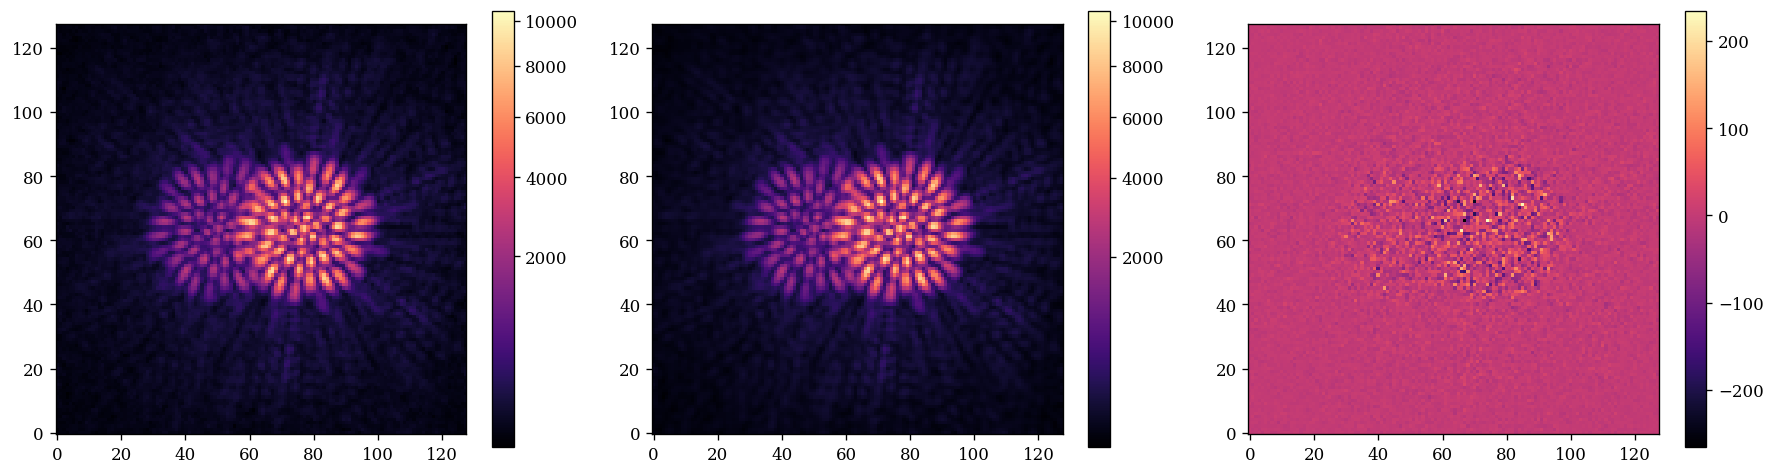

In [7]:
import matplotlib as mpl
d = datas['lin']

n = jr.poisson(jr.PRNGKey(0), d)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(n, norm=mpl.colors.PowerNorm(gamma=0.5))
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(d, norm=mpl.colors.PowerNorm(gamma=0.5))
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(d-n)
plt.colorbar()

plt.tight_layout()
plt.show()

In [63]:
sep_dict_save_dir = "/media/morgana2/max/data/toliman/sep_dicts/jitsep/"

Models:   0%|          | 0/3 [00:00<?, ?it/s]

Data Arrays:   0%|          | 0/3 [00:00<?, ?it/s]

Noise Realisations:   0%|          | 0/1 [00:00<?, ?it/s]

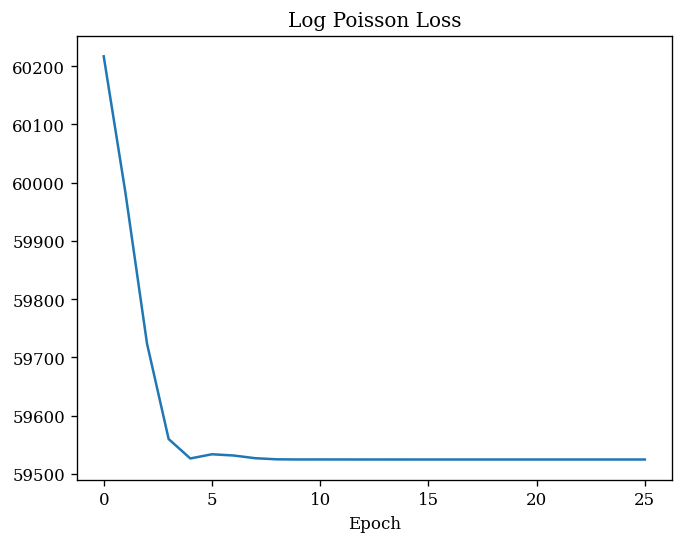

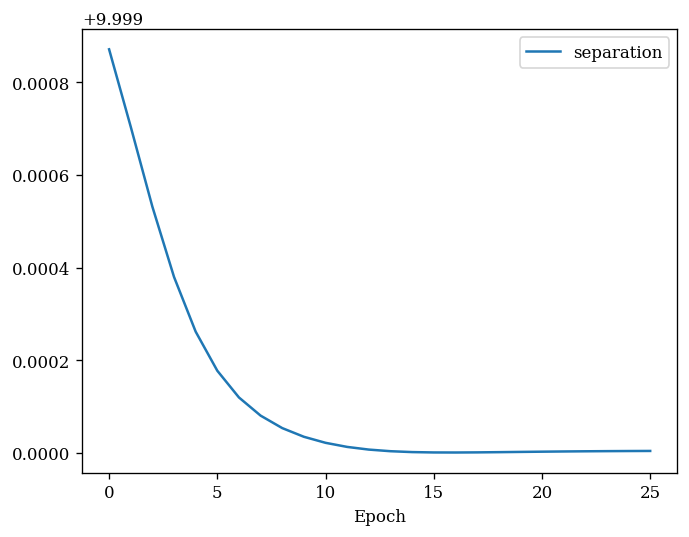

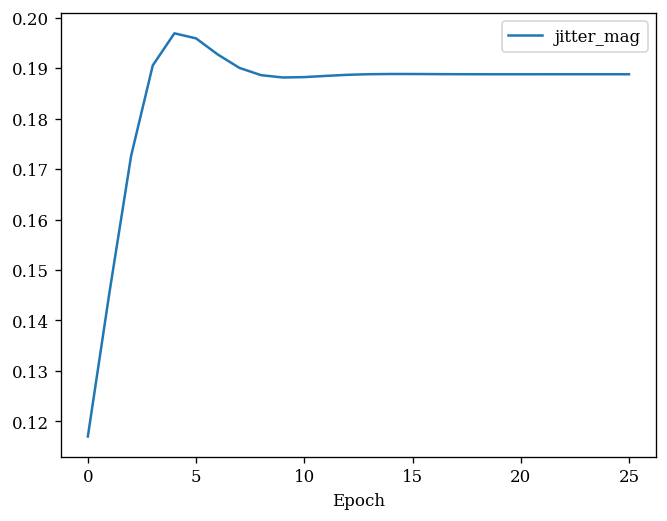

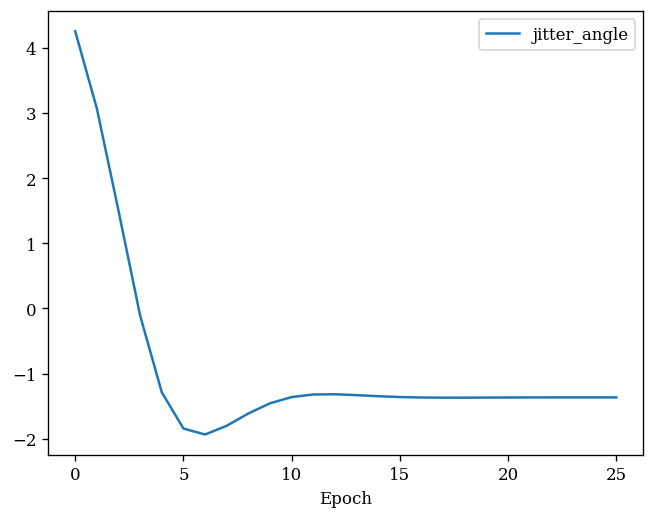

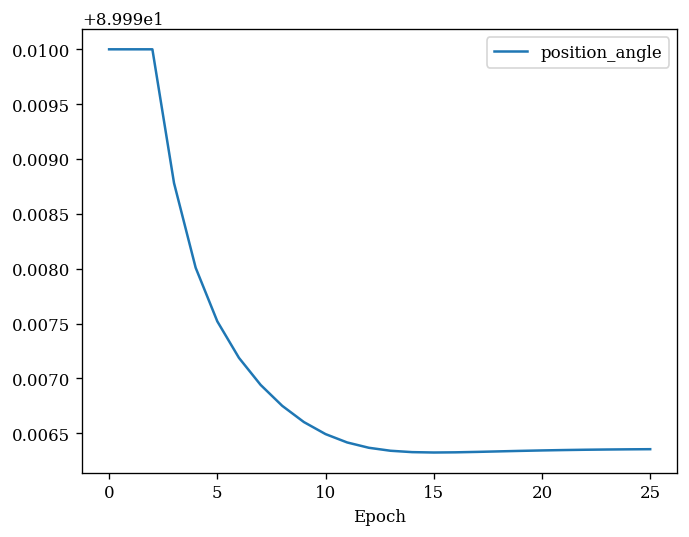

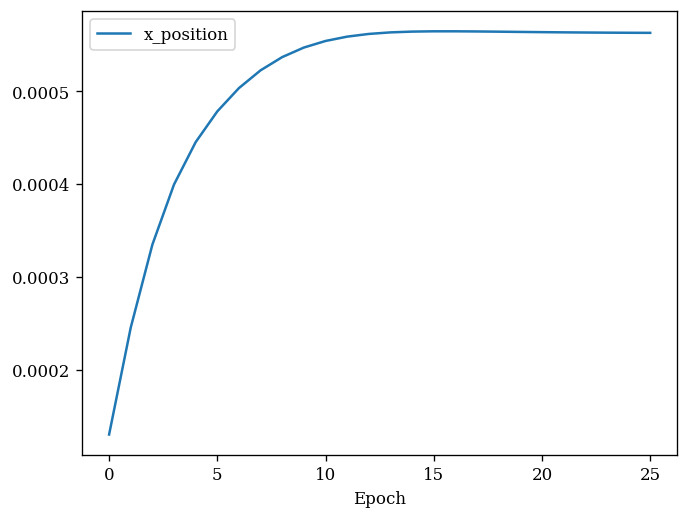

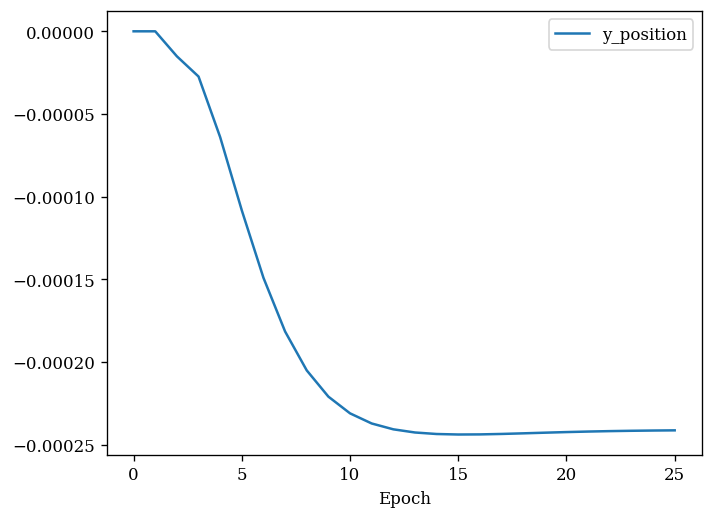

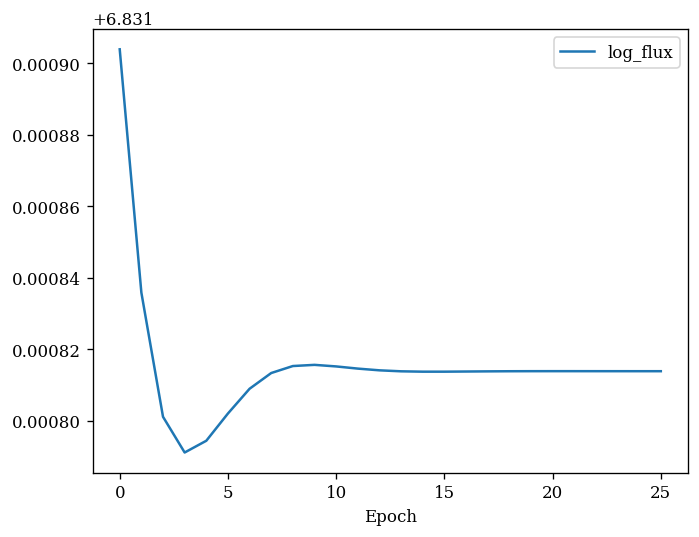

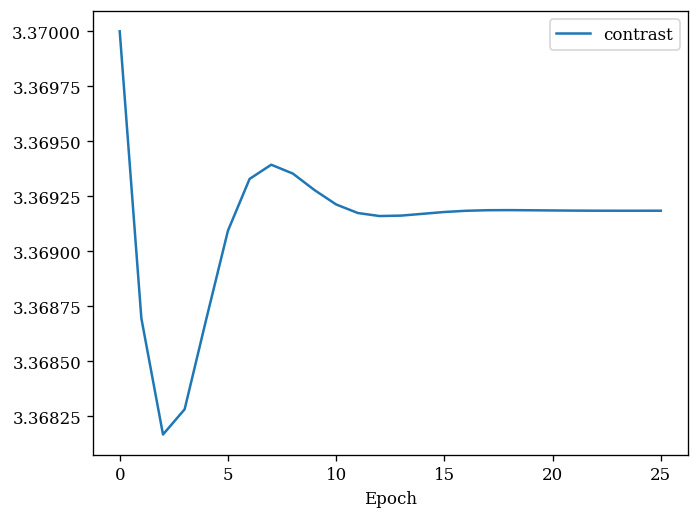

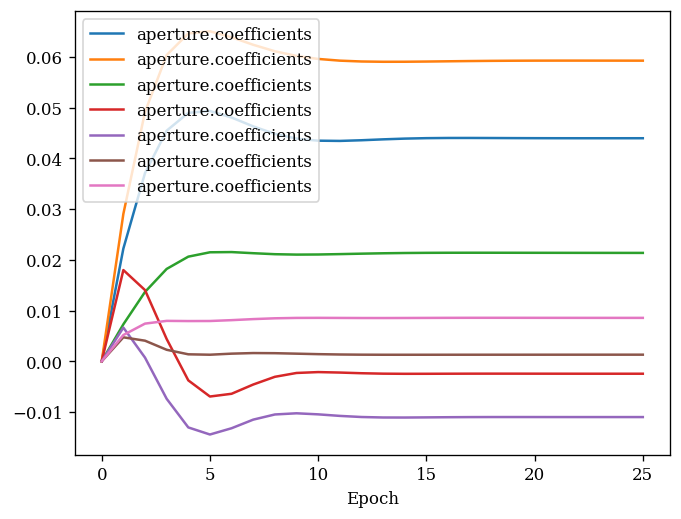

ValueError: Stop here

In [ ]:
import random
from datetime import datetime

sep_dict = {}
n_realisations = 1

# Gradient descent
optimisers = {
    # "separation": adam(2.5e-5, 0),
    # 'psf_pixel_scale': adam(1e-5, 0),  
    # 'mean_wavelength': adam(2e-3, 20),
    "separation": sgd(5e-8, 0),
    "jitter_mag": sgd(1.5e-6, 0),
    "jitter_angle": sgd(3e-1, 0),
    'position_angle': sgd(2e-6, 3),
    'x_position': sgd(1.5e-8, 0),
    'y_position': sgd(1.5e-8, 2),
    'log_flux': sgd(1e-8, 0),
    'contrast': sgd(6e-6, 1),
    'aperture.coefficients': sgd(1e-3, 0),
}
    # 'psf_pixel_scale': sgd(1e-10, 30),  
    # 'mean_wavelength': sgd(2e-4, 0),
    # 'wavelengths': sgd(8e-4, 0),

@zdx.filter_jit
@zdx.filter_value_and_grad(list(optimisers.keys()))
def loss_func_jitter(model, data):
    model_array = model.jitter_model()
    return -np.nansum(jsp.stats.poisson.logpmf(data, model_array))
    
@zdx.filter_jit
@zdx.filter_value_and_grad(list(optimisers.keys()))
def loss_func_normal(model, data):
    model_array = model.model()
    return -np.nansum(jsp.stats.poisson.logpmf(data, model_array))


for model_key in tqdm(models.keys(), desc="Models"):
    model = models[model_key]

    if model_key == "norm":
        continue
        jitter_flag = False
        loss_func = loss_func_normal
    else:
        jitter_flag = True
        loss_func = loss_func_jitter

    for data_key in tqdm(datas.keys(), desc='Data Arrays'):
        data = datas[data_key]
        sep_values = np.array([], dtype=np.float64)
        
        for i in tqdm(range(n_realisations), desc='Noise Realisations'):

            noisy_data = jr.poisson(
                jr.PRNGKey(random.randint(0, int(1e8))), 
                data,
                )

            gd_model = run_grad_desc(
                model,
                noisy_data,
                list(optimisers.keys()),
                optimisers=list(optimisers.values()),
                iters=50,
                loss_func=loss_func,
                plot=True,
                verbose=False,
                eps=3e-4,
            )

            raise ValueError("Stop here")

            sep_values = np.append(sep_values, gd_model.separation)

        sep_dict[f"{model_key}_{data_key}"] = sep_values

current_time = datetime.now().strftime('%d-%m-%Y_%H-%M')
save_str = current_time + f"_{n_realisations:04d}.npy"

# np.save(os.path.join(sep_dict_save_dir, save_str), sep_dict)

In [64]:
total_sep_dict = {}

# looping over saved sep_dicts
for f in os.listdir(sep_dict_save_dir):
    if not f.endswith(".npy"):
        continue

    # loading each file
    this_dict = np.load(os.path.join(sep_dict_save_dir, f), allow_pickle=True).item()
    
    # appending to total_sep_dict
    for k in this_dict.keys():
        total_sep_dict[k] = np.append(total_sep_dict[k], this_dict[k]) if k in total_sep_dict.keys() else this_dict[k]


951
-5.797297830812636e-06 0.00048563734840955747
-9.175502895708203e-06 0.00046446183324530695
1.9677446916299373e-05 0.0004662637096471945
-2.6866896374868733e-06 0.0004619793626681558
-2.7935128956206932e-05 0.0004592675635812394
-1.4116258851594724e-05 0.00046560451262799495


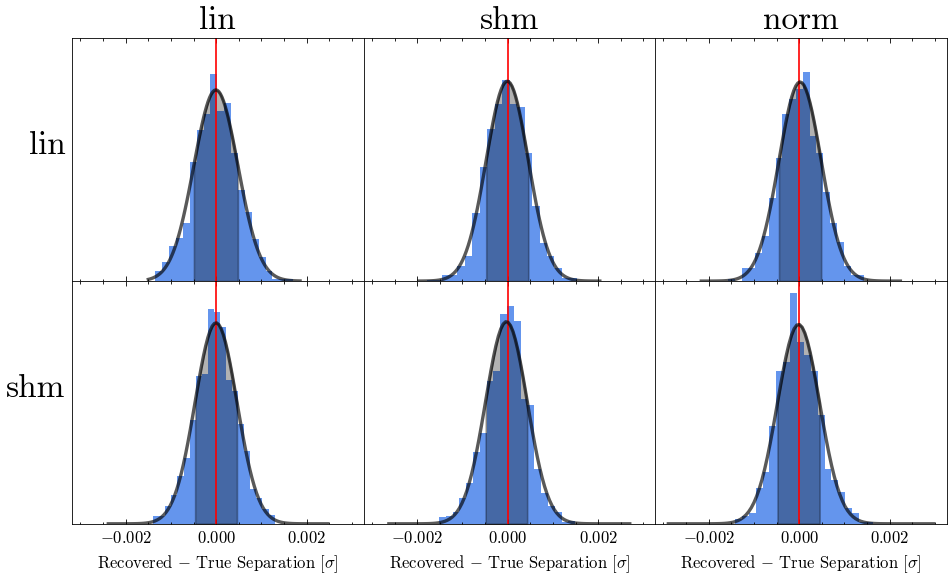

In [65]:
%matplotlib inline

import scienceplots
plt.style.use(['science', 'bright', 'no-latex'])

print(len(list(total_sep_dict.values())[0]))

n_bins = 20
true_sep = 10.0  # arcseconds
fontsize = 20
fisher_sigma = 2.56e-3  # arcseconds

fig, ax = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True)
fig.subplots_adjust(
    top=0.915,
    bottom=0.106,
    left=0.074,
    right=0.985,
    hspace=0.0,
    wspace=0.0,
    )

for i in range(2):
    for j in range(3):

        # mu, sigma = jax.scipy.stats.norm.fit(results[key])
        key = f"{list(models.keys())[i]}_{list(datas.keys())[j]}"
        # results = np.load(f"data/biases/{key}.npy")
        results = total_sep_dict[key]
        offset_hist = (results - true_sep) # in arseconds
        # offset_hist /= fisher_sigma  # converting to sigma units


        ax[i][j].hist(
            offset_hist,
            bins=n_bins,
            density=True,
            color="cornflowerblue",
            alpha=1.,
            )
        ax[i][j].set(
            title=f"{key}",
            xlabel=r'Recovered $-$ True Separation [$\sigma$]',
            # xlim=(-3.2, 3.2),
            # xticks=range(-3, 4),
            yticks=[],
            )
        
        ax[i][j].axvline(0, color='red', linestyle='-')

        # Generate the best-fit normal distribution curve
        mu = np.mean(offset_hist)
        std = np.std(offset_hist)

        print(mu, std)

        xmin, xmax = plt.xlim()
        
        xs = np.linspace(xmin, xmax, 100)
        bell_curve = jax.scipy.stats.norm.pdf(xs, mu, std)

        one_sigma_xs = np.linspace(mu - std, mu + std, 100)
        one_sigma_bell = jax.scipy.stats.norm.pdf(one_sigma_xs, mu, std)

        # Plot the normal distribution curve
        ax[i][j].plot(xs, bell_curve, 'black', linewidth=2, alpha=.65)
        ax[i][j].fill_between(one_sigma_xs, one_sigma_bell, color='black', alpha=0.3, zorder=1)

        if j == 0:
            ax[i][j].set_ylabel(f"{list(models.keys())[i]}", fontsize=fontsize, rotation=0, ha='right')
        else:
            ax[i][j].set(
                ylabel=None,
            )
        if i == 0:
            ax[i][j].set(
                xlabel=None,
            )
            ax[i][j].set_title(f"{list(datas.keys())[j]}", fontsize=fontsize)  # Set the text size of the title
        else:
            ax[i][j].set(
                title=None,
            )

# plt.tight_layout()
# plt.savefig('figs/biases.png', dpi=500)
plt.show()


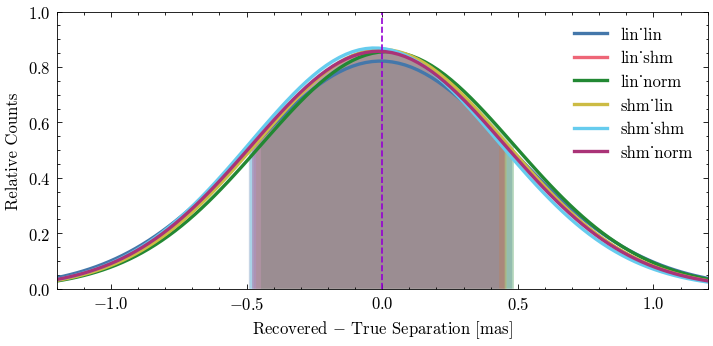

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.set(
    # title='All Biases',
    xlabel=r'Recovered $-$ True Separation [mas]',
    ylabel="Relative Counts",
    # yticks=[],
    ylim=(0, None),
    xlim=(-1.2, 1.2),
    )

for key, seps in total_sep_dict.items():

    offset_hist = 1e3 * (seps - true_sep)  # in milliarcseconds

    # ax.hist(
    #     offset_hist,
    #     bins=n_bins,
    #     density=True,
    #     alpha=0.5,
    #     # label=key,
    #     )
    
    # Generate the best-fit normal distribution curve
    mu = np.mean(offset_hist)
    std = np.std(offset_hist)

    xmin, xmax = plt.xlim()
    
    xs = np.linspace(xmin, xmax, 100)
    bell_curve = jax.scipy.stats.norm.pdf(xs, mu, std)

    one_sigma_xs = np.linspace(mu - std, mu + std, 100)
    one_sigma_bell = jax.scipy.stats.norm.pdf(one_sigma_xs, mu, std)

    # Plot the normal distribution curve
    ax.plot(xs, bell_curve, linewidth=2, label=key)
    ax.fill_between(one_sigma_xs, one_sigma_bell, alpha=0.3, zorder=1)
    
ax.axvline(0, color='darkviolet', linestyle='--')
plt.legend()
plt.show()